## Real-Time Cyber Attacks Detection using Streaming Isolation Forest
- Traditional network traffic security systems have primarily relied on rule-based or signature-based Intrusion Detection Systems (IDS). However, in industrial environments such as the Industrial Internet of Things (IIoT), the increasing volume of high-speed, encrypted, and high-dimensional traffic has made it difficult for such methods to provide effective protection.

- As a result, [machine learning techniques—particularly supervised learning models—have been increasingly applied in the cybersecurity domain](https://www.mdpi.com/1999-4893/18/4/209?utm_source=chatgpt.com), enabling the development of intelligent intrusion detection systems (IDS) capable of real-time anomaly detection and alert generation. While unsupervised methods such as Isolation Forest are widely used, this study instead leverages a supervised Random Forest approach, which is more appropriate given that most potential attack types are already labeled in the dataset, as discussed in the following EDA section.

- Accordingly, this study places emphasis on not only training an effective Random Forest classifier, but also integrating it into an end-to-end real-time alert system suitable for production-level deployment.

## Cyber attack data
[The dataset utilized in this study](https://research.unsw.edu.au/projects/unsw-nb15-dataset) was curated by the University of New South Wales (UNSW), Australia, and originates from network traffic captured at the Cyber Range Lab of UNSW Canberra. It consists of two separate subsets for training and testing purposes, each containing labeled records that simulate a wide array of real-world cyber attacks.

Specifically, the dataset encompasses nine distinct categories of malicious activity:

- **Fuzzers**, which test system stability by injecting random or malformed inputs;

- **Analysis**, where attackers probe and monitor systems to uncover exploitable weaknesses;

- **Backdoors**, designed to establish hidden channels for future unauthorized access;

- **Denial of Service (DoS)** attacks that aim to overload and disrupt system availability;

- **Exploits**, which take advantage of known software or configuration vulnerabilities;

- **Generic attacks**, a broad category for miscellaneous intrusion patterns;

- **Reconnaissance**, involving systematic information gathering to map out potential targets;

- **Shellcode**, where malicious code is executed directly on the host system;

- And **Worms**, self-replicating programs that propagate across networks, often causing widespread disruption.

Together, these attack types represent a diverse set of intrusion methods, making the dataset particularly valuable for training and evaluating anomaly detection systems in realistic threat environments.



## Import and Set up

In [130]:
import numpy as np
import pandas as pd

from IPython.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings

# Configure Jupyter Notebook
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

reload(plt)
%matplotlib inline
%config InlineBackend.figure_format ='retina'

warnings.filterwarnings('ignore')

# configure plotly graph objects
pio.renderers.default = 'browser'
# pio.renderers.default = 'vscode'

pio.templates["ck_template"] = go.layout.Template(
    layout_colorway = px.colors.sequential.Viridis, 
#     layout_hovermode = 'closest',
#     layout_hoverdistance = -1,
    layout_autosize=False,
    layout_width=800,
    layout_height=600,
    layout_font = dict(family="Calibri Light"),
    layout_title_font = dict(family="Calibri"),
    layout_hoverlabel_font = dict(family="Calibri Light"),
#     plot_bgcolor="white",
)
 
# pio.templates.default = 'seaborn+ck_template+gridon'
pio.templates.default = 'ck_template+gridon'
# pio.templates.default = 'seaborn+gridon'
# pio.templates

In [131]:
def reduce_column(s, to_keep):
    '''
    Reduces the string values found in a column
    to the values provided in the list 'to_keep'.
    ---
    Input:
        s: string
        to_keep: list of strings
    Returns:
        string, s if s should be kept, else 'other'
    '''
    s = s.lower().strip()
    if s not in to_keep:
        return 'other'
    else:
        return s

In [132]:
df = pd.read_csv('../data/UNSW_NB15_training-set.csv')

In [133]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [143]:
df['proto'].value_counts()

proto
tcp            79946
udp            63283
unas           12084
arp             2859
ospf            2595
sctp            1150
any              300
gre              225
sun-nd           201
ipv6             201
mobile           201
swipe            201
pim              201
rsvp             200
sep              193
ib               101
mtp              100
skip             100
merit-inp        100
sps              100
ptp              100
fire             100
smp              100
isis             100
pri-enc          100
srp              100
l2tp             100
stp              100
iatp             100
vrrp             100
compaq-peer      100
ddp              100
aris             100
etherip          100
scps             100
qnx              100
idpr             100
larp             100
sccopmce         100
mhrp             100
iplt             100
crudp            100
vines            100
uti              100
secure-vmtp      100
visa             100
ippc             100
ddx    

In [142]:
df['dpkts'].value_counts()

dpkts
0        84282
8        17287
6        12262
2         9238
10        6825
18        6533
12        4098
4         3655
24        2991
14        2642
42        2317
22        2234
50        1904
62        1645
20        1617
54        1324
40        1106
126       1033
30         919
74         836
16         828
26         797
438        537
66         535
28         502
70         499
68         495
36         438
746        423
92         416
858        308
86         286
114        249
38         235
80         228
44         221
32         220
34         209
58         199
52         177
60         161
48         151
46         144
64          94
72          94
116         77
90          77
56          58
78          49
388         47
106         44
124         41
112         40
84          39
88          31
512         31
82          31
122         31
118         30
76          29
110         29
94          29
560         26
164         24
594         23
162         22
368 

## Unusual Distribution for Anomaly Detection
As you can see below, this dataset is intentionally imbalanced, with approximately 68% of the data labeled as anomalous. While this does not reflect real-world distributions (where anomalies are typically rare), such a configuration is useful for evaluating and comparing detection models under controlled conditions.



In [ ]:
sns.histplot(
    data=df,             
    x='label',         
    bins=2,              
    discrete=True,       
    color='skyblue'     
)

plt.title('Histogram of Label (0: Normal, 1: Anomaly)') 
plt.xlabel('Label')                                    
plt.ylabel('Count')                                    
plt.xticks([0, 1])                                      

plt.show()

In [ ]:
df.head(30)

In [ ]:
df.describe(include='all')

attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64


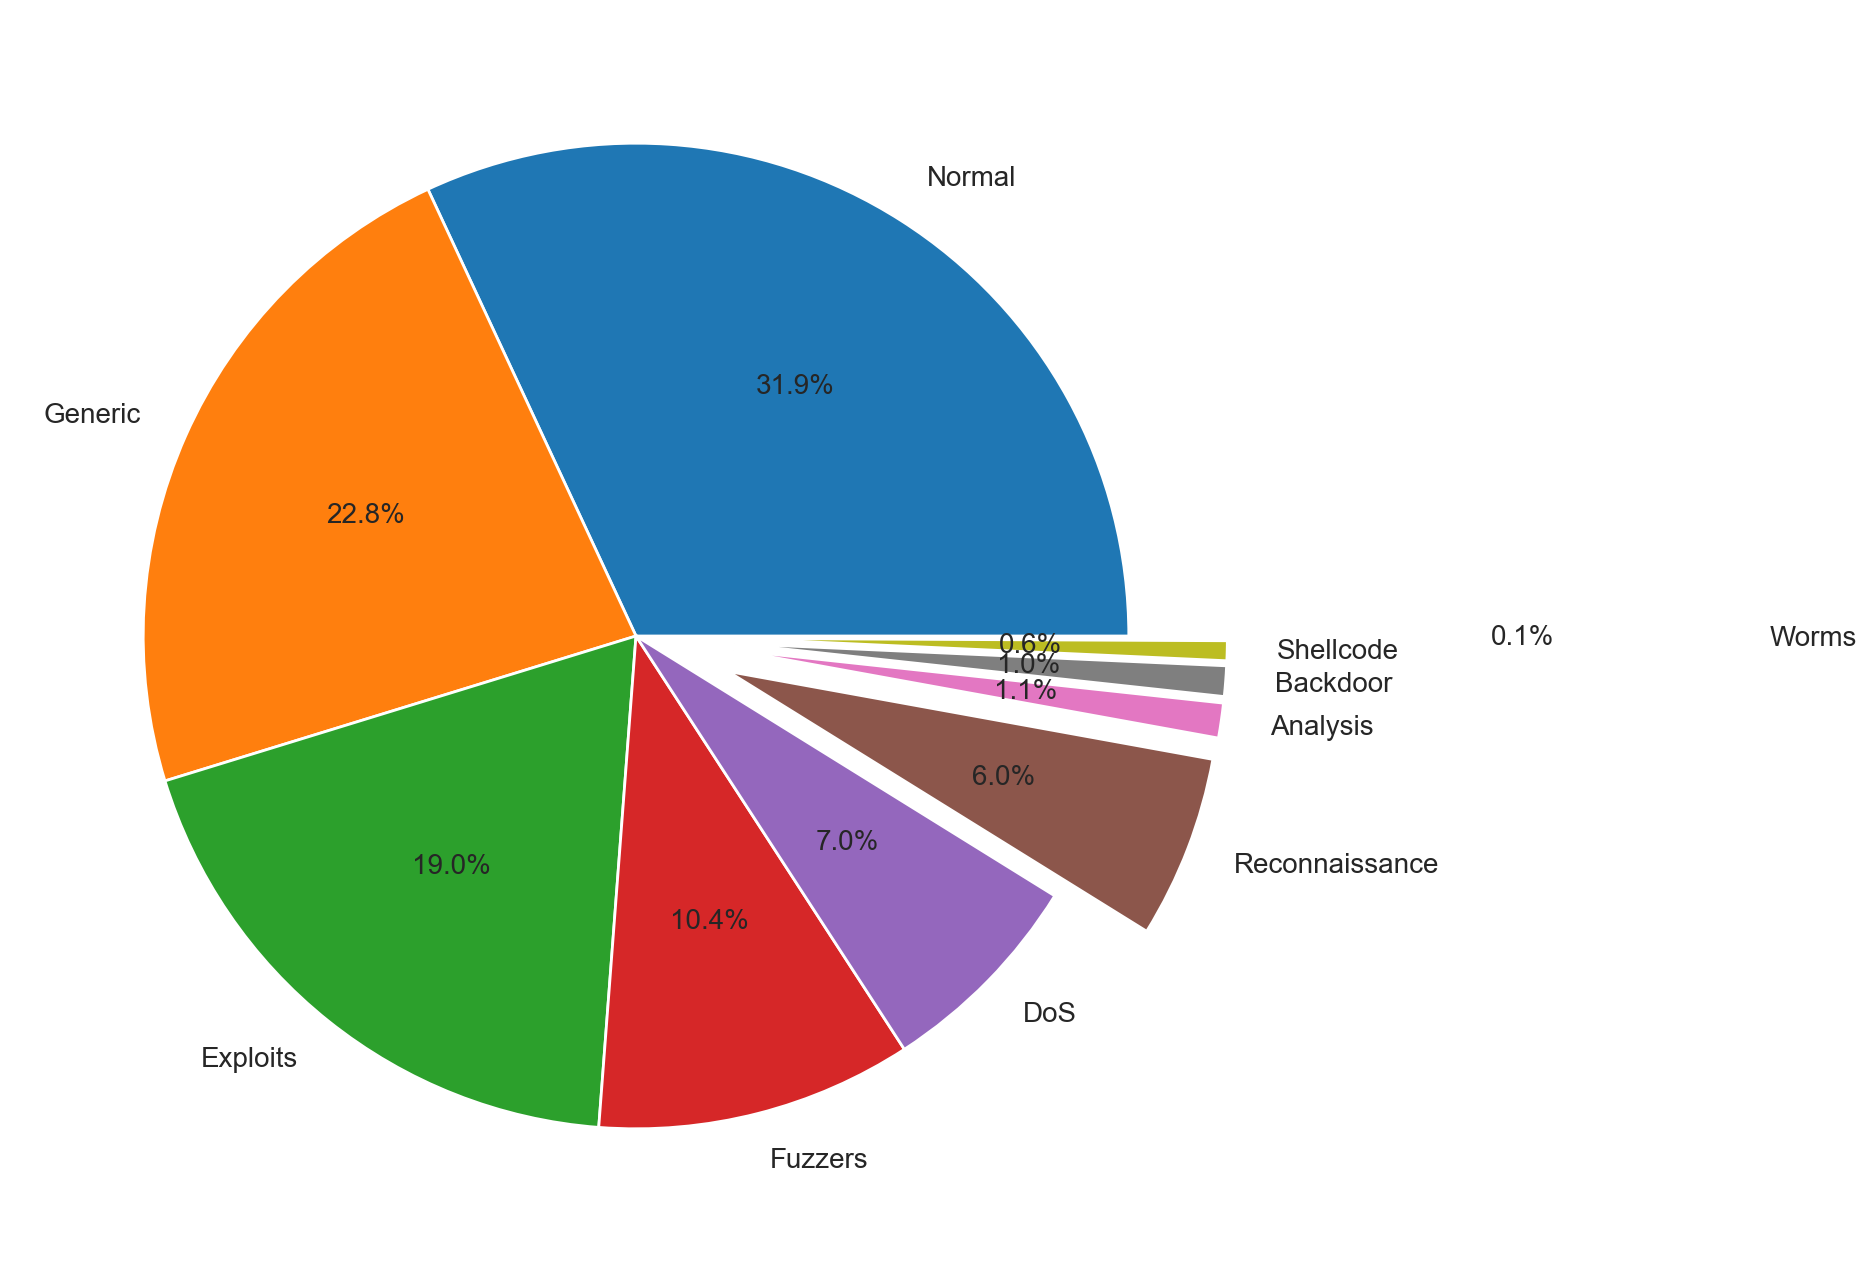

In [73]:
validAttacks = df['attack_cat'].value_counts()
print(validAttacks)

plt.figure(figsize = (15,8))
plt.pie(validAttacks,labels = validAttacks.index, autopct = '%1.1f%%',explode = [0,0,0,0,0,0.2,0.2,0.2,0.2,1.2])
plt.show()

## Pre-processing and Feature Selection
As part of the pre-processing pipeline, several features were evaluated for potential removal to improve model performance and ensure generalizability.

- The `id` column, which merely serves as a row index without offering any predictive value, was removed.

- The `attack_cat` feature, while informative, is a categorical description derived directly from the target label. Including it would artificially inflate model accuracy without contributing to true generalization; thus, it was excluded.

- Other features were analyzed for multicollinearity and excessive correlation. However, in the current version of the model, no additional features were dropped. Instead, the full set was retained to allow initial evaluation of the model’s performance before applying further dimensionality reduction or correlation-based filtering.



In [74]:
list_drop = ['id', 'attack_cat']

In [75]:
df.drop(list_drop, axis=1, inplace=True)

## Clamping Extreme Values
To mitigate skewness in feature distributions, clamping was applied selectively to prune extreme values. Specifically, features whose maximum values exceeded ten times their median were identified as candidates for clamping. In such cases, values above the 95th percentile were capped at that threshold.

However, care was taken to preserve meaningful variation in the data. If the 95th percentile was found to be too close to the maximum, clamping was avoided to retain potentially informative long-tail behavior. Additionally, features with smaller dynamic ranges or bimodal distributions were excluded from this transformation to prevent distortion of their underlying structure.

This targeted approach helps reduce the impact of extreme outliers without compromising the integrity of features that carry important distributional signals.


In [76]:
# Clamp extreme Values
df_numeric = df.select_dtypes(include=[np.number])
df_numeric.describe(include='all')

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,175341.000000,175341.000000,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,175341.000000,1.753410e+05,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,175341.000000,175341.000000,1.753410e+05,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000
mean,1.359389,20.298664,18.969591,8.844844e+03,1.492892e+04,9.540619e+04,179.546997,79.609567,7.345403e+07,6.712056e+05,4.953000,6.948010,985.976864,88.216296,4.976254e+03,604.353826,116.257339,9.692504e+08,9.688770e+08,115.013625,0.041396,0.021020,0.020375,136.751769,124.173382,0.105982,2.144292e+03,9.306437,1.304179,6.193936,5.383538,4.206255,8.729881,0.014948,0.014948,0.133066,6.955789,9.100758,0.015752,0.680622
std,6.480249,136.887597,110.258271,1.747656e+05,1.436542e+05,1.654010e+05,102.940011,110.506863,1.883574e+08,2.421312e+06,66.005059,52.732999,7242.245841,987.093195,4.496585e+04,4061.043281,127.001024,1.355264e+09,1.354000e+09,126.886530,0.079354,0.043400,0.040506,204.677360,258.317056,0.776911,5.420797e+04,10.704331,0.954406,8.052476,8.047104,5.783585,10.956186,0.126048,0.126048,0.701208,8.321493,10.756952,0.124516,0.466237
min,0.000000,1.000000,0.000000,2.800000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.278614e+01,62.000000,0.000000,1.305334e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,0.001582,2.000000,2.000000,4.300000e+02,1.640000e+02,3.225807e+03,254.000000,29.000000,8.796748e+05,1.447023e+03,0.000000,0.000000,0.279733,0.006000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,73.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,0.668069,12.000000,10.000000,1.418000e+03,1.102000e+03,1.250000e+05,254.000000,252.000000,8.888889e+07,2.784487e+04,3.000000,2.000000,55.156896,51.053000,2.513295e+03,114.990625,255.000000,1.916651e+09,1.913675e+09,255.000000,0.065481,0.023268,0.038906,100.000000,89.000000,0.000000,0.000000e+00,12.000000,2.000000,7.000000,5.000000,3.000000,12.000000,0.000000,0.000000,0.000000,9.000000,12.000000,0.000000,1.000000
max,59.999989,9616.000000,10974.000000,1.296523e+07,1.465555e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,2.242273e+07,4803.000000,5484.000000,84371.496000,56716.824000,1.460480e+06,289388.269700,255.000000,4.294959e+09,4.294882e+09,255.000000,2.518893,2.100352,1.520884,1504.000000,1458.000000,172.000000,6.558056e+06,63.000000,6.000000,51.000000,51.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


In [77]:
DEBUG =0

clamp_thresholds = {}
for feature in df_numeric.columns:
    if DEBUG == 1:
        print(feature)
        print('max = '+str(df_numeric[feature].max()))
        print('75th = '+str(df_numeric[feature].quantile(0.95)))
        print('median = '+str(df_numeric[feature].median()))
        print(df_numeric[feature].max()>10*df_numeric[feature].median())
        print('----------------------------------------------------')

    clamp_thresholds[feature] = {
        'max': df_numeric[feature].max(),
        '95th': df_numeric[feature].quantile(0.95),
        'median': df_numeric[feature].median()
    }

    if clamp_thresholds[feature]['max'] > 10 * clamp_thresholds[feature]['median'] and clamp_thresholds[feature]['max'] > 10:
        df[feature] = np.where(df[feature] < clamp_thresholds[feature]['95th'], df[feature], clamp_thresholds[feature]['95th'])

    '''
    if df_numeric[feature].max()>10*df_numeric[feature].median() and df_numeric[feature].max()>10 : 
        df[feature] = np.where(df[feature]<df[feature].quantile(0.95), df[feature], df[feature].quantile(0.95))
    '''

In [78]:
clamp_thresholds

{'dur': {'max': np.float64(59.999989),
  '95th': np.float64(3.079511),
  'median': np.float64(0.001582)},
 'spkts': {'max': np.int64(9616),
  '95th': np.float64(64.0),
  'median': np.float64(2.0)},
 'dpkts': {'max': np.int64(10974),
  '95th': np.float64(62.0),
  'median': np.float64(2.0)},
 'sbytes': {'max': np.int64(12965233),
  '95th': np.float64(13662.0),
  'median': np.float64(430.0)},
 'dbytes': {'max': np.int64(14655550),
  '95th': np.float64(39076.0),
  'median': np.float64(164.0)},
 'rate': {'max': np.float64(1000000.003),
  '95th': np.float64(333333.3215),
  'median': np.float64(3225.80652)},
 'sttl': {'max': np.int64(255),
  '95th': np.float64(254.0),
  'median': np.float64(254.0)},
 'dttl': {'max': np.int64(254),
  '95th': np.float64(252.0),
  'median': np.float64(29.0)},
 'sload': {'max': np.float64(5988000256.0),
  '95th': np.float64(266666656.0),
  'median': np.float64(879674.75)},
 'dload': {'max': np.float64(22422730.0),
  '95th': np.float64(4071050.0),
  'median': np.f

In [79]:
import joblib
joblib.dump(clamp_thresholds, '../model/clamp_thresholds.pkl')

['../model/clamp_thresholds.pkl']

### Apply log function to nearly all numeric, since they are all mostly skewed to the right

It would have been too much of a slog to apply the log function individually, therefore a simple rule has been set up: if the number of unique values in the continuous feature is more than 50 then apply the log function. The reason more than 50 unique values are sought is to filter out the integer based features that act more categorically.

In [80]:
df_numeric = df.select_dtypes(include=[np.number])
df_before = df_numeric.copy()
DEBUG = 0

log_thresholds = {}

for feature in df_numeric.columns:
    if DEBUG == 1:
        print(feature)
        print('nunique = '+str(df_numeric[feature].nunique()))
        print(df_numeric[feature].nunique()>50)
        print('----------------------------------------------------')

    log_thresholds[feature] = {
        'nunique': df_numeric[feature].nunique(),
        'min': df_numeric[feature].min()
    }
    
    if log_thresholds[feature]['nunique'] > 50:
        if log_thresholds[feature]['min'] == 0:
            df[feature] = np.log(df[feature] + 1)
        else:
            df[feature] = np.log(df[feature])

df_numeric = df.select_dtypes(include=[np.number])

In [81]:
log_thresholds

{'dur': {'nunique': 68719, 'min': np.float64(0.0)},
 'spkts': {'nunique': 36, 'min': np.float64(1.0)},
 'dpkts': {'nunique': 34, 'min': np.float64(0.0)},
 'sbytes': {'nunique': 3601, 'min': np.float64(28.0)},
 'dbytes': {'nunique': 4493, 'min': np.float64(0.0)},
 'rate': {'nunique': 76989, 'min': np.float64(0.0)},
 'sttl': {'nunique': 11, 'min': np.int64(0)},
 'dttl': {'nunique': 6, 'min': np.int64(0)},
 'sload': {'nunique': 79205, 'min': np.float64(0.0)},
 'dload': {'nunique': 68985, 'min': np.float64(0.0)},
 'sloss': {'nunique': 13, 'min': np.float64(0.0)},
 'dloss': {'nunique': 25, 'min': np.float64(0.0)},
 'sinpkt': {'nunique': 73285, 'min': np.float64(0.0)},
 'dinpkt': {'nunique': 66888, 'min': np.float64(0.0)},
 'sjit': {'nunique': 70140, 'min': np.float64(0.0)},
 'djit': {'nunique': 69465, 'min': np.float64(0.0)},
 'swin': {'nunique': 13, 'min': np.float64(0.0)},
 'stcpb': {'nunique': 66892, 'min': np.float64(0.0)},
 'dtcpb': {'nunique': 66750, 'min': np.float64(0.0)},
 'dwin': 

In [82]:
import joblib
joblib.dump(log_thresholds, '../model/log_thresholds.pkl')

['../model/log_thresholds.pkl']

### Reduce the labels in catagorical features
Some features have very high cardinalities, and this section reduces the cardinality to 5 or 6 per feature. The logic is to take the top 5 occuring labels in the feature as the labels and set the remainder to '-' (seldom used) labels. When the encoding is done later on, the dimensionality will not explode and cause the curse of dimensionality.

In [83]:
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

,proto,service,state
count,175341,175341,175341
unique,133,13,9
top,tcp,-,INT
freq,79946,94168,82275


In [84]:
DEBUG = 0

cat_thresholds = {}
for feature in df_cat.columns:
    if DEBUG == 1:
        print(feature)
        print('nunique = '+str(df_cat[feature].nunique()))
        print(df_cat[feature].nunique()>6)
        print(sum(df[feature].isin(df[feature].value_counts().head().index)))
        print('----------------------------------------------------')
    
    cat_thresholds[feature] = {
        'nunique': df_cat[feature].nunique(),
        'top_values': df_cat[feature].value_counts().head().index.tolist()
    }
    
    if cat_thresholds[feature]['nunique'] > 6:
        df[feature] = np.where(df[feature].isin(cat_thresholds[feature]['top_values']), df[feature], '-')

In [85]:
cat_thresholds

{'proto': {'nunique': 133,
  'top_values': ['tcp', 'udp', 'unas', 'arp', 'ospf']},
 'service': {'nunique': 13,
  'top_values': ['-', 'dns', 'http', 'smtp', 'ftp-data']},
 'state': {'nunique': 9, 'top_values': ['INT', 'FIN', 'CON', 'REQ', 'RST']}}

In [86]:
import joblib
joblib.dump(cat_thresholds, '../model/cat_thresholds.pkl')

['../model/cat_thresholds.pkl']

In [87]:
# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

best_features = SelectKBest(score_func=chi2,k='all')

X = df.iloc[:,4:-2]
y = df.iloc[:,-1]
fit = best_features.fit(X,y)

df_scores=pd.DataFrame(fit.scores_)
df_col=pd.DataFrame(X.columns)

feature_score=pd.concat([df_col,df_scores],axis=1)
feature_score.columns=['feature','score']
feature_score.sort_values(by=['score'],ascending=True,inplace=True)

fig = go.Figure(go.Bar(
            x=feature_score['score'][0:21],
            y=feature_score['feature'][0:21],
            orientation='h'))

fig.update_layout(title="Top 20 Features",
                  height=1200,
                  showlegend=False,
                 )

fig.show()


## Encode categorical features
The categorical variables should be encoded because the models cannot interpret 'string'. As such, One-hot encoding is utilized because none of them are ordinal. 

In [88]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [89]:
X.head()
feature_names = list(X.columns)
np.shape(X)

(175341, 42)

In [90]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [1,2,3])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

joblib.dump(ct, '../model/one_hot_encoder.pkl')

['../model/one_hot_encoder.pkl']

In [91]:
np.shape(X)

(175341, 56)

## Modelling and Evaluation

### Prep for Modelling

First, in this section, the data is split into test and training sets using stratified sampling as prep for modelling.

In [92]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0,
                                                    stratify=y)

### Standardize continuous features

a standard scaler is used on the continuous features to put them all in the same order of size.

In [93]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[:, 18:] = sc.fit_transform(X_train[:, 18:])
joblib.dump(sc, '../model/standard_scaler.pkl')
X_test[:, 18:] = sc.transform(X_test[:, 18:])

### Import Metrics

Imports the libraries that will be used to evaluate the models later on

In [94]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import time
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','time to train','time to predict','total time'])

## Random Forest Modelling
Although anomaly detection is often tackled using unsupervised methods such as Isolation Forest, this study adopts a supervised Random Forest approach. This decision is based on the observation—detailed in the EDA section—that the dataset already contains labeled attack types, allowing for effective classification-based detection aligned with real-time alerting needs.

Furthermore, as demonstrated by the evaluation metrics below, the Random Forest model exhibited strong performance in detecting anomalies.

In [95]:
%%time
from sklearn.ensemble import RandomForestClassifier
start = time.time()
model = RandomForestClassifier(n_estimators = 100,n_jobs=-1,random_state=0,bootstrap=True,).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

CPU times: user 17.4 s, sys: 597 ms, total: 18 s
Wall time: 4.99 s


In [96]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Random Forest'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 95.93%
Recall: 95.93%
Precision: 95.92%
F1-Score: 95.92%
time to train: 4.65 s
time to predict: 0.15 s
total: 4.80 s


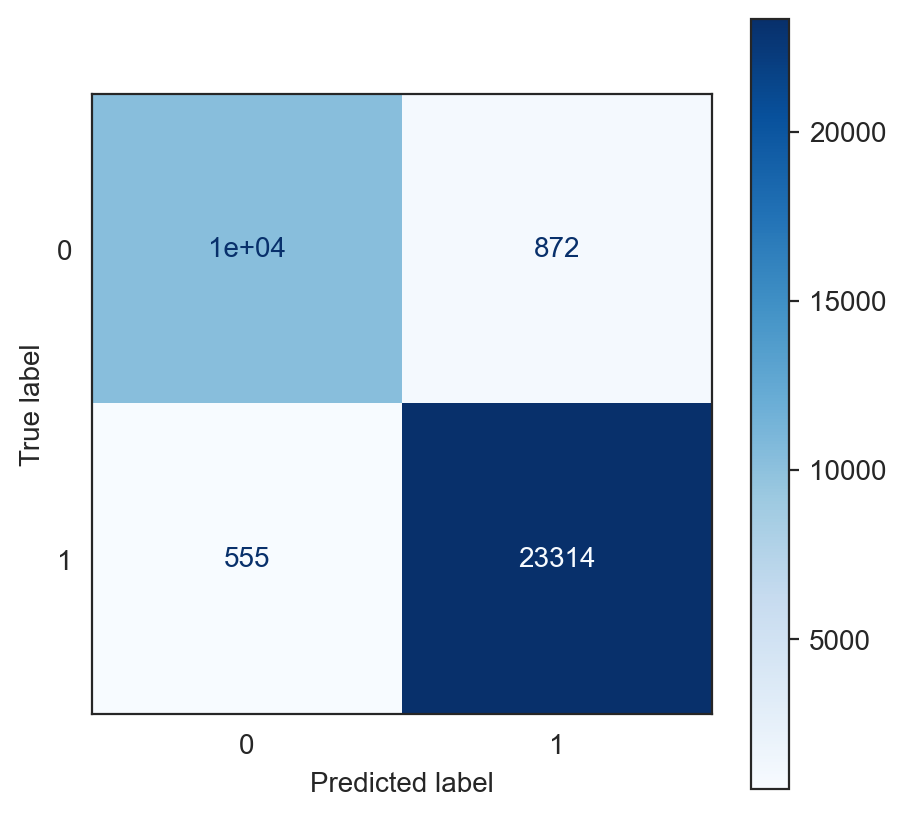

In [97]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

## Full Dataset EDA
The current train-test split is balanced, but I’m reviewing the full dataset to better understand class distribution and feature characteristics. After completing initial feature engineering and model selection, the plan is to retrain the model on the entire dataset. 

In [98]:
dfs = []
for i in range(1, 5):
    path = '../data/UNSW-NB15_{}.csv'
    dfs.append(pd.read_csv(path.format(i), header = None))
all_data = pd.concat(dfs).reset_index(drop=True)
all_data.columns = pd.read_csv('../data/UNSW-NB15_features.csv', encoding='latin1').Name.apply(lambda x: x.lower())

In [99]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  sload             float64
 15  dload             float64
 16  spkts             int64  
 17  dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  sjit          

In [100]:
## Column cleaning steps: some of the CSV's leave the point blank for zero values.
## This results in Pandas loading in NaN values in columns where it otherwise expects numeric values. 
# Fill all NaN attack categories w/ value: 'normal'
all_data['attack_cat'] = all_data.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())
# Replace blank spaces with zero
all_data['ct_ftp_cmd'] = all_data.ct_ftp_cmd.replace(to_replace=' ', value=0).astype(int)
# Replace NaN with zero
all_data['ct_flw_http_mthd'] = all_data.ct_flw_http_mthd.fillna(value=0)
# Replace NaN with zero and all values > 0 with 1
all_data['is_ftp_login'] = (all_data.is_ftp_login.fillna(value=0) >0).astype(int)

## Reduce categorical features into smaller sets:
## Ex: 135 unique values in `proto` become "tcp", "udp", "arp", "unas", and "other"
transformations = {
    'proto':['tcp', 'udp', 'arp', 'unas'],
    'state':['fin', 'con', 'int'],
    'service':['-', 'dns']
}
for col, keepers in transformations.items():
    all_data[col] = all_data[col].apply(reduce_column, args=(keepers,))

all_data.shape

(2540047, 49)

In [101]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  sload             float64
 15  dload             float64
 16  spkts             int64  
 17  dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  sjit          

In [102]:
# Fraction of connections that are attacks: roughly 12.6%
np.sum(all_data.label == 1)/all_data.shape[0]

np.float64(0.12648702957071267)

In [103]:
# Confirm missing data has been addressed in processes above
all_data.isnull().sum().sum()

np.int64(0)

In [104]:
# Compare columns in larger csv files w/ those in partitioned training and test sets
full_cols = set(all_data.columns)
train_cols = set(df.columns)

# Number of columns the two datasets have in common:
print('No. of common columns:', len(train_cols.intersection(full_cols)))

#Columns in training data not in raw CSV's
print(train_cols - full_cols)

# Columns in raw CSV's not in training data
print(full_cols - train_cols)

No. of common columns: 36
{'rate', 'sinpkt', 'ct_src_ltm', 'dmean', 'smean', 'response_body_len', 'dinpkt'}
{'dmeansz', 'ltime', 'dsport', 'attack_cat', 'smeansz', 'sport', 'srcip', 'sintpkt', 'res_bdy_len', 'ct_src_ ltm', 'stime', 'dintpkt', 'dstip'}


Note that IP address and port numbers are not included in the data set, and that we've used the id column as an index. Pre-dropped columns:

- id
- srcip
- sport
- dstip
- dsport

This brings us to 42 data columns that we'll have to use as features and 2 columns to use as target values, depending on whether I want to tackle a binary or multiclass classification problem.

In [105]:
# As before, I'll drop the `attack_cat` column.
list_drop = ['srcip', 'sport', 'dstip', 'dsport', 'attack_cat']
all_data.drop(list_drop, axis=1, inplace=True)

In [106]:
# Clamp extreme Values
all_data_numeric = all_data.select_dtypes(include=[np.number])
all_data_numeric.describe(include='all')

Name,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,label
count,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06
mean,6.587916e-01,4.339600e+03,3.642759e+04,6.278197e+01,3.076681e+01,5.163921e+00,1.632944e+01,3.695645e+07,2.450861e+06,3.328884e+01,4.272664e+01,1.500887e+02,1.497459e+02,1.261701e+09,1.261766e+09,1.242536e+02,2.766719e+02,8.325318e-02,4.242118e+03,1.589037e+03,7.300755e+02,1.423261e+09,1.423261e+09,1.933225e+02,7.882476e+01,6.180475e-03,3.287595e-03,2.892880e-03,1.651544e-03,2.611546e-01,1.100779e-01,1.715519e-02,2.055789e-02,9.206988e+00,8.988958e+00,6.439103e+00,6.900986e+00,4.642139e+00,3.592729e+00,6.845886e+00,1.264870e-01
std,1.392493e+01,5.640599e+04,1.610960e+05,7.462277e+01,4.285089e+01,2.251707e+01,5.659474e+01,1.186043e+08,4.224863e+06,7.628388e+01,1.215020e+02,1.254824e+02,1.255438e+02,1.422027e+09,1.422139e+09,1.519162e+02,3.356166e+02,3.500045e-01,4.750053e+04,1.691036e+04,3.438558e+03,1.134449e+06,1.134448e+06,2.779163e+03,1.433191e+03,4.615863e-02,2.593570e-02,2.394668e-02,4.060563e-02,6.830974e-01,5.564195e-01,1.298495e-01,1.843620e-01,1.083676e+01,1.082249e+01,8.162034e+00,8.205062e+00,8.477579e+00,6.174445e+00,1.125828e+01,3.323975e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.421927e+09,1.421927e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.037000e-03,2.000000e+02,1.780000e+02,3.100000e+01,2.900000e+01,0.000000e+00,0.000000e+00,1.353963e+05,1.191594e+04,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+01,6.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.421952e+09,1.421952e+09,9.000000e-03,6.000000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,1.586100e-02,1.470000e+03,1.820000e+03,3.100000e+01,2.900000e+01,3.000000e+00,4.000000e+00,5.893038e+05,5.893179e+05,1.200000e+01,1.200000e+01,2.550000e+02,2.550000e+02,6.397250e+08,6.384172e+08,7.300000e+01,8.900000e+01,0.000000e+00,0.000000e+00,1.912490e+01,2.653561e+00,1.424227e+09,1.424227e+09,4.682620e-01,4.147550e-01,6.130000e-04,4.830000e-04,1.220000e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,5.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00
75%,2.145545e-01,3.182000e+03,1.489400e+04,3.100000e+01,2.900000e+01,7.000000e+00,1.400000e+01,2.039923e+06,2.925974e+06,4.400000e+01,4.200000e+01,2.550000e+02,2.550000e+02,2.467160e+09,2.469411e+09,1.320000e+02,5.650000e+02,0.000000e+00,0.000000e+00,4.137935e+02,6.350857e+01,1.424245e+09,1.424245e+09,7.351427e+00,6.202100e+00,7.020000e-04,5.540000e-04,1.400000e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000

In [107]:
DEBUG =0

full_clamp_thresholds = {}
for feature in all_data_numeric.columns:
    if DEBUG == 1:
        print(feature)
        print('max = '+str(all_data_numeric[feature].max()))
        print('75th = '+str(all_data_numeric[feature].quantile(0.95)))
        print('median = '+str(all_data_numeric[feature].median()))
        print(all_data_numeric[feature].max()>10*all_data_numeric[feature].median())
        print('----------------------------------------------------')

    full_clamp_thresholds[feature] = {
        'max': all_data_numeric[feature].max(),
        '95th': all_data_numeric[feature].quantile(0.95),
        'median': all_data_numeric[feature].median()
    }

    if full_clamp_thresholds[feature]['max'] > 10 * full_clamp_thresholds[feature]['median'] and full_clamp_thresholds[feature]['max'] > 10:
        all_data[feature] = np.where(all_data[feature] < full_clamp_thresholds[feature]['95th'], all_data[feature], full_clamp_thresholds[feature]['95th'])

In [108]:
clamp_thresholds

{'dur': {'max': np.float64(59.999989),
  '95th': np.float64(3.079511),
  'median': np.float64(0.001582)},
 'spkts': {'max': np.int64(9616),
  '95th': np.float64(64.0),
  'median': np.float64(2.0)},
 'dpkts': {'max': np.int64(10974),
  '95th': np.float64(62.0),
  'median': np.float64(2.0)},
 'sbytes': {'max': np.int64(12965233),
  '95th': np.float64(13662.0),
  'median': np.float64(430.0)},
 'dbytes': {'max': np.int64(14655550),
  '95th': np.float64(39076.0),
  'median': np.float64(164.0)},
 'rate': {'max': np.float64(1000000.003),
  '95th': np.float64(333333.3215),
  'median': np.float64(3225.80652)},
 'sttl': {'max': np.int64(255),
  '95th': np.float64(254.0),
  'median': np.float64(254.0)},
 'dttl': {'max': np.int64(254),
  '95th': np.float64(252.0),
  'median': np.float64(29.0)},
 'sload': {'max': np.float64(5988000256.0),
  '95th': np.float64(266666656.0),
  'median': np.float64(879674.75)},
 'dload': {'max': np.float64(22422730.0),
  '95th': np.float64(4071050.0),
  'median': np.f

In [109]:
import joblib
joblib.dump(full_clamp_thresholds, '../model/full_clamp_thresholds.pkl')

['../model/full_clamp_thresholds.pkl']

In [110]:
# Apply log transformation to numeric columns
all_data_numeric = all_data.select_dtypes(include=[np.number])
all_data_before = all_data_numeric.copy()
DEBUG = 0

full_log_thresholds = {}

for feature in all_data_numeric.columns:
    if DEBUG == 1:
        print(feature)
        print('nunique = '+str(all_data_numeric[feature].nunique()))
        print(all_data_numeric[feature].nunique()>50)
        print('----------------------------------------------------')

    full_log_thresholds[feature] = {
        'nunique': all_data_numeric[feature].nunique(),
        'min': all_data_numeric[feature].min()
    }

    if full_log_thresholds[feature]['nunique'] > 50:
        if full_log_thresholds[feature]['min'] == 0:
            all_data[feature] = np.log(all_data[feature] + 1)
        else:
            all_data[feature] = np.log(all_data[feature])

all_data_numeric = all_data.select_dtypes(include=[np.number])

In [111]:
full_log_thresholds

{'dur': {'nunique': 480718, 'min': np.float64(0.0)},
 'sbytes': {'nunique': 7086, 'min': np.float64(0.0)},
 'dbytes': {'nunique': 12191, 'min': np.float64(0.0)},
 'sttl': {'nunique': 13, 'min': np.int64(0)},
 'dttl': {'nunique': 11, 'min': np.int64(0)},
 'sloss': {'nunique': 20, 'min': np.float64(0.0)},
 'dloss': {'nunique': 37, 'min': np.float64(0.0)},
 'sload': {'nunique': 1097576, 'min': np.float64(0.0)},
 'dload': {'nunique': 1077031, 'min': np.float64(0.0)},
 'spkts': {'nunique': 123, 'min': np.float64(0.0)},
 'dpkts': {'nunique': 127, 'min': np.float64(0.0)},
 'swin': {'nunique': 36, 'min': np.int64(0)},
 'dwin': {'nunique': 32, 'min': np.int64(0)},
 'stcpb': {'nunique': 1429571, 'min': np.int64(0)},
 'dtcpb': {'nunique': 1429031, 'min': np.int64(0)},
 'smeansz': {'nunique': 603, 'min': np.float64(0.0)},
 'dmeansz': {'nunique': 867, 'min': np.float64(0.0)},
 'trans_depth': {'nunique': 2, 'min': np.float64(0.0)},
 'res_bdy_len': {'nunique': 1875, 'min': np.float64(0.0)},
 'sjit': 

In [112]:
import joblib
joblib.dump(full_log_thresholds, '../model/full_log_thresholds.pkl')

['../model/full_log_thresholds.pkl']

In [113]:
# Reduce categorical features into smaller sets:
all_df_cat = all_data.select_dtypes(exclude=[np.number])
all_df_cat.describe(include='all')

Name,proto,state,service
count,2540047,2540047,2540047
unique,5,4,3
top,tcp,fin,-
freq,1495074,1478689,1246397


In [114]:
DEBUG = 0

full_cat_thresholds = {}
for feature in all_df_cat.columns:
    if DEBUG == 1:
        print(feature)
        print('nunique = '+str(all_df_cat[feature].nunique()))
        print(all_df_cat[feature].nunique()>6)
        print(sum(all_df_cat[feature].isin(all_df_cat[feature].value_counts().head().index)))
        print('----------------------------------------------------')

    full_cat_thresholds[feature] = {
        'nunique': all_df_cat[feature].nunique(),
        'top_values': all_df_cat[feature].value_counts().head().index.tolist()
    }

    if full_cat_thresholds[feature]['nunique'] > 6:
        all_data[feature] = np.where(all_data[feature].isin(full_cat_thresholds[feature]['top_values']), all_data[feature], '-')

In [115]:
full_cat_thresholds

{'proto': {'nunique': 5, 'top_values': ['tcp', 'udp', 'other', 'unas', 'arp']},
 'state': {'nunique': 4, 'top_values': ['fin', 'con', 'int', 'other']},
 'service': {'nunique': 3, 'top_values': ['-', 'dns', 'other']}}

In [116]:
import joblib
joblib.dump(full_cat_thresholds, '../model/full_cat_thresholds.pkl')

['../model/full_cat_thresholds.pkl']

In [117]:
X = all_data.iloc[:,:-1]
y = all_data.iloc[:,-1]

In [118]:
X.head()
feature_names = list(X.columns)
np.shape(X)

(2540047, 43)

In [119]:
full_ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), ['proto', 'state', 'service'])], remainder='passthrough')
X = np.array(full_ct.fit_transform(X))

joblib.dump(full_ct, '../model/full_one_hot_encoder.pkl')

['../model/full_one_hot_encoder.pkl']

In [120]:
np.shape(X)

(2540047, 52)

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0,
                                                    stratify=y)

In [122]:
full_sc = StandardScaler()
X_train[:, 18:] = full_sc.fit_transform(X_train[:, 18:])
joblib.dump(full_sc, '../model/full_standard_scaler.pkl')
X_test[:, 18:] = full_sc.transform(X_test[:, 18:])

In [123]:
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','time to train','time to predict','total time'])

In [124]:
start = time.time()
model = RandomForestClassifier(n_estimators = 100,n_jobs=-1,random_state=0,bootstrap=True,).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()
with open('full_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [125]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Random Forest'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 99.59%
Recall: 99.59%
Precision: 99.59%
F1-Score: 99.59%
time to train: 95.98 s
time to predict: 1.35 s
total: 97.33 s


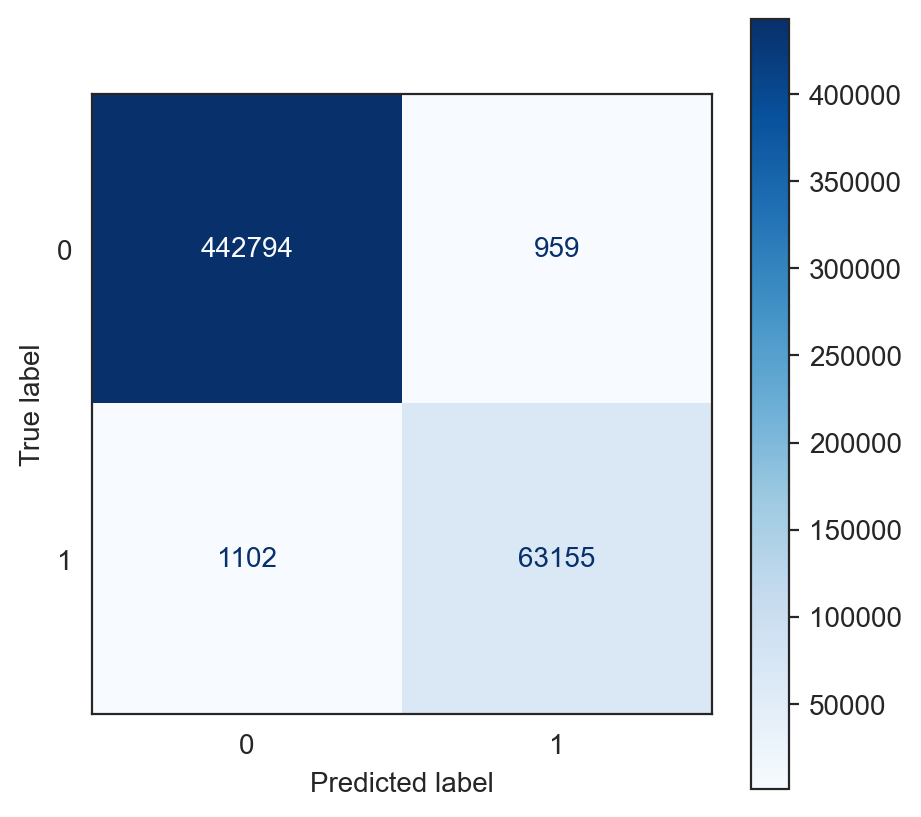

In [126]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

In [127]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
data_3d = pca.fit_transform(StandardScaler().fit_transform(
    all_data.select_dtypes(exclude='object').drop(columns=['dtcpb', 'stcpb'])))

mask = all_data.label==1

In [128]:
%matplotlib notebook

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_3d[mask, 0], data_3d[mask, 1], data_3d[mask, 2],
           label='normal data', alpha=0.6)
ax.scatter(data_3d[~mask, 0], data_3d[~mask, 1], data_3d[~mask, 2],
           label='attack data', alpha=0.6)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()

plt.show()


<IPython.core.display.Javascript object>

In [129]:
pca.explained_variance_ratio_

array([0.39889197, 0.13239363, 0.09417054])